# Edge Detection II
Author: Chul Min Yeum  
Email: cmyeum@uwaterloo.ca  

Last updated: 2024-02-11

## Table of Contents
* Filter Images with Derivatives of Gaussian  
* Non-maximum Suppression (1D)  
* Non-maximum Suppression  
* Effect of Gaussian Kernel Sizes  
* Effect of High and Low Threshold  
* Beam  

## Filter Images with Derivatives of Gaussian 

0.0


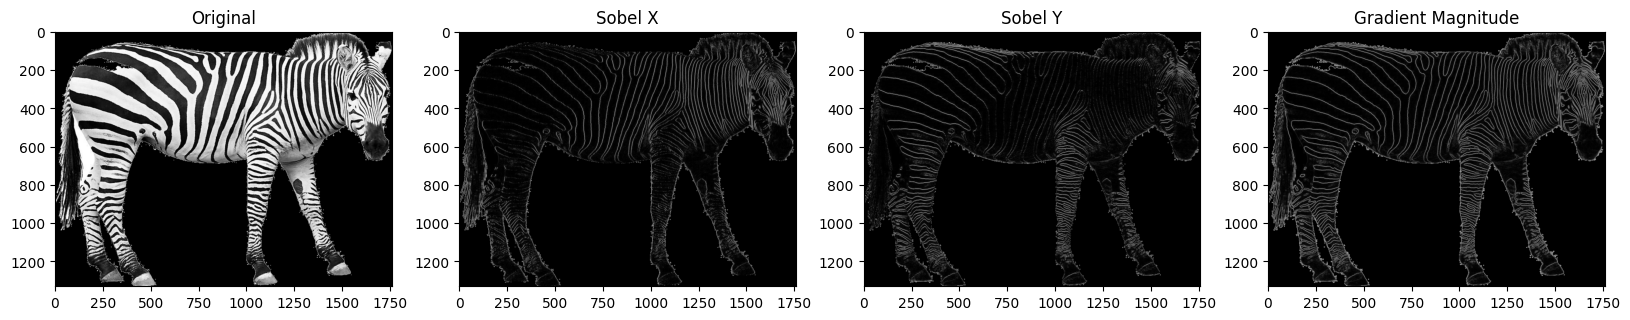

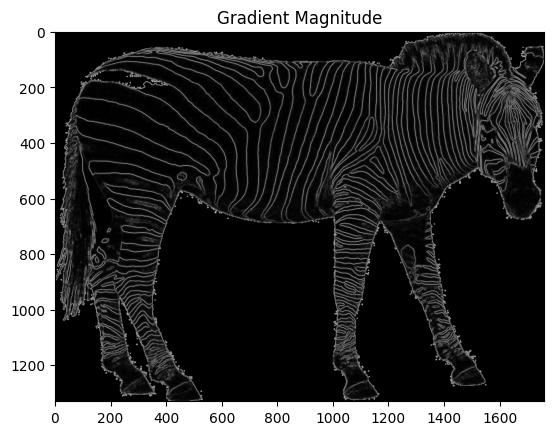

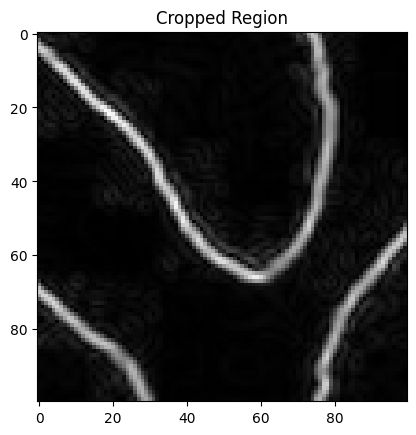

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve

# Load the image and convert to grayscale
img = Image.open('PinClipart.com_duck-clip-art-black_522802.png').convert('L')

# Resize the image
img_resized = img.resize([int(0.8 * s) for s in img.size], Image.Resampling.LANCZOS)

# Convert image to numpy array and normalize to range 0 to 1
img_array = np.asarray(img_resized) / 255.0

# Define Sobel operators
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

sobel_x = prewitt_x.copy()
sobel_x[1, 0] = -2
sobel_x[1, 2] = 2

sobel_y = -sobel_x.T

# Apply Sobel operators
fx = convolve(img_array, sobel_x)
fy = convolve(img_array, sobel_y)
fxy = np.sqrt(fx**2 + fy**2)

# Display the images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(img_array, cmap='gray')
axs[0].set_title('Original')
axs[1].imshow(abs(fx), cmap='gray')
axs[1].set_title('Sobel X')
axs[2].imshow(abs(fy), cmap='gray')
axs[2].set_title('Sobel Y')
axs[3].imshow(fxy, cmap='gray')
axs[3].set_title('Gradient Magnitude')

print(np.min(fxy))

# Display gradient magnitude in a separate figure
plt.figure()
plt.imshow(fxy, cmap='gray')
plt.title('Gradient Magnitude')

# Crop a specific region from the gradient magnitude image and display it
# Note: Adjust cropping coordinates if necessary
crop_x, crop_y, crop_width, crop_height = 660, 262, 100, 100
img_cropped = fxy[crop_y:crop_y+crop_height, crop_x:crop_x+crop_width]

plt.figure()
plt.imshow(img_cropped, cmap='gray')
plt.title('Cropped Region')

plt.show()


## Non-maximum Suppression (1D)

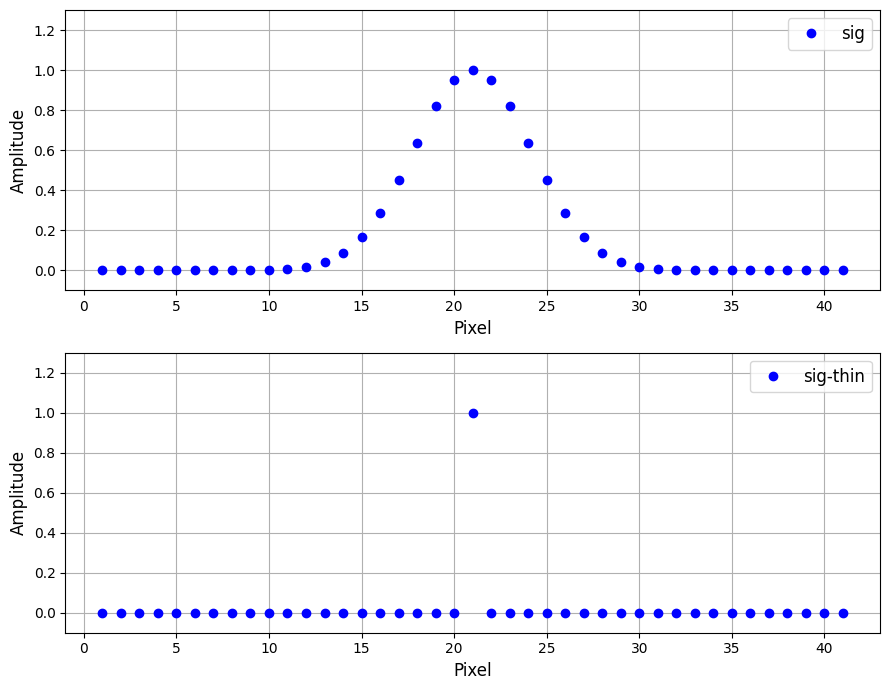

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import sys

# Parameters
a = 5

# Define the original signal as a function of t
def x(t):
    return np.exp(-a * t**2)

# Define the signal in the Fourier domain as a function of t and w
def x_in(t, w):
    return x(t) * np.exp(-1j * w * t)

# Define the Fourier transform of x as a function of w
def Xw(w):
    result, _ = quad(lambda t: x_in(t, w), -np.inf, np.inf)
    return result

# Define the analytic solution of the Fourier transform of x
def Xw_analytic(w):
    return np.sqrt(np.pi / a) * np.exp(-w**2 / (4 * a))

# Time and frequency domains
t = np.arange(-2, 2.1, 0.1)
# Using numpy.finfo(float).tiny to avoid division by zero issues
w = np.arange(-12, 12.1, 0.1) + np.finfo(float).tiny

# Calculate amplitude of the signal
amp = x(t)

# Thinning the amplitude by retaining only local maxima
amp_thin = np.zeros_like(amp)
for ii in range(1, len(t) - 1):
    amp_thin[ii] = amp[ii] if amp[ii] == max(amp[ii-1], amp[ii], amp[ii+1]) else 0

# Plotting
plt.figure(figsize=(9, 7))

# Plot original signal amplitude
plt.subplot(211)
plt.plot(range(1, len(t)+1), amp, 'ob', linewidth=2)
plt.legend(['sig'], fontsize=12)
plt.grid(True)
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.ylim([-0.1, 1.3])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Plot thinned signal amplitude
plt.subplot(212)
plt.plot(range(1, len(t)+1), amp * amp_thin, 'ob', linewidth=2)
plt.legend(['sig-thin'], fontsize=12)
plt.grid(True)
plt.ylabel('Amplitude', fontsize=12)
plt.xlabel('Pixel', fontsize=12)
plt.ylim([-0.1, 1.3])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


## Non-maximum Suppression

<div>
<img src="canny_dir.png" width="200"/>
</div>


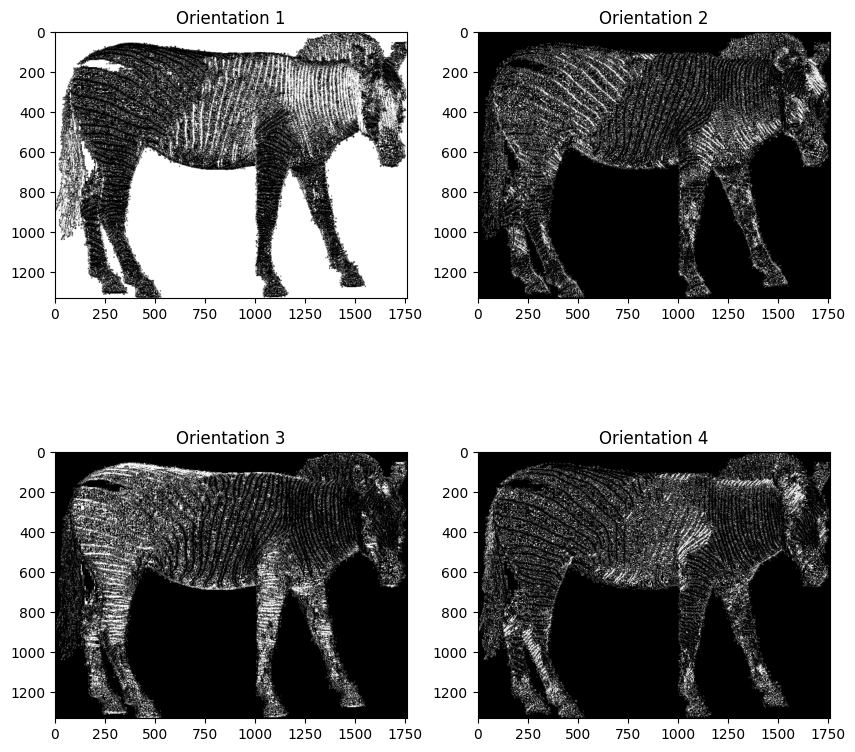

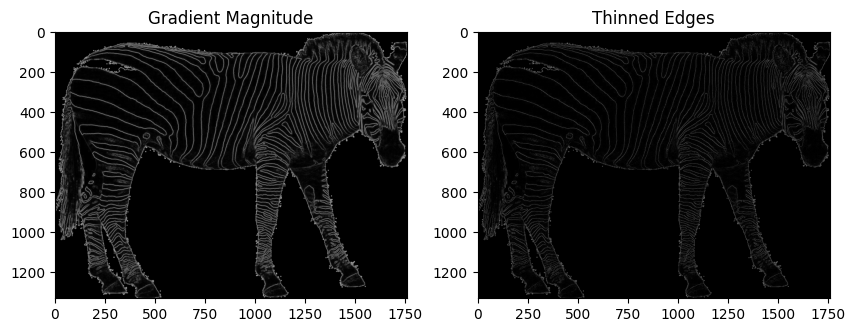

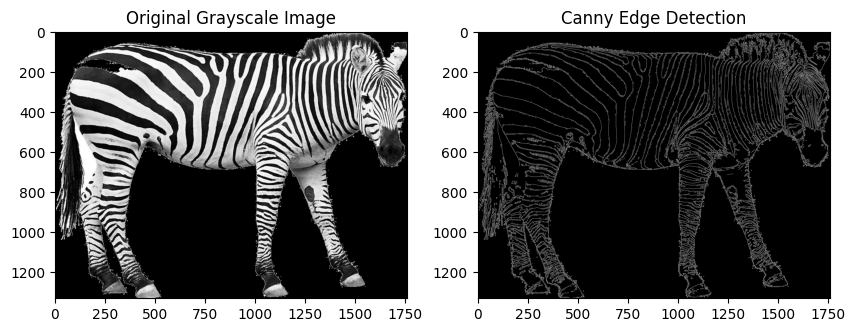

True

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read and preprocess the image
img = cv2.imread('PinClipart.com_duck-clip-art-black_522802.png', cv2.IMREAD_GRAYSCALE)
imgg = cv2.resize(img, None, fx=0.8, fy=0.8, interpolation=cv2.INTER_AREA)
imgg = imgg.astype(np.float32) / 255.0  # Convert to float

# Define Sobel and Prewitt kernels
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitt_y = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

sobel_x = prewitt_x.copy()
sobel_x[1, 0] = -2
sobel_x[1, 2] = 2
sobel_y = -sobel_x.T

# Apply filters
fx = cv2.filter2D(imgg, -1, sobel_x)
fy = cv2.filter2D(imgg, -1, sobel_y)
fxy = np.sqrt(fx**2 + fy**2)

aimg = np.arctan2(fy, fx) * 180 / np.pi
aimg[aimg < 0] += 360

# Classify orientations
conditions = [
    (aimg > 337.5) | (aimg <= 22.5) | ((aimg > 157.5) & (aimg <= 202.5)),
    ((aimg > 22.5) & (aimg <= 67.5)) | ((aimg > 202.5) & (aimg <= 247.5)),
    ((aimg > 67.5) & (aimg <= 112.5)) | ((aimg > 247.5) & (aimg <= 292.5)),
    ((aimg > 112.5) & (aimg <= 157.5)) | ((aimg > 292.5) & (aimg <= 337.5)),
]
choices = [1, 2, 3, 4]

aimg_classified = np.select(conditions, choices, default=0)

# Edge thinning
img_bw = np.zeros_like(aimg_classified)
for i in range(1, img_bw.shape[0] - 1):
    for j in range(1, img_bw.shape[1] - 1):
        if aimg_classified[i, j] == 1:
            img_bw[i, j] = fxy[i, j] == max(fxy[i, j-1], fxy[i, j], fxy[i, j+1])
        elif aimg_classified[i, j] == 2:
            img_bw[i, j] = fxy[i, j] == max(fxy[i-1, j+1], fxy[i, j], fxy[i+1, j-1])
        elif aimg_classified[i, j] == 3:
            img_bw[i, j] = fxy[i, j] == max(fxy[i-1, j], fxy[i, j], fxy[i+1, j])
        elif aimg_classified[i, j] == 4:
            img_bw[i, j] = fxy[i, j] == max(fxy[i-1, j-1], fxy[i, j], fxy[i+1, j+1])

# Visualization
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(aimg_classified == 1, cmap='gray'), plt.title('Orientation 1')
plt.subplot(222), plt.imshow(aimg_classified == 2, cmap='gray'), plt.title('Orientation 2')
plt.subplot(223), plt.imshow(aimg_classified == 3, cmap='gray'), plt.title('Orientation 3')
plt.subplot(224), plt.imshow(aimg_classified == 4, cmap='gray'), plt.title('Orientation 4')
plt.show()

# Edge thinning visualization
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(fxy, cmap='gray'), plt.title('Gradient Magnitude')
plt.subplot(122), plt.imshow(fxy * img_bw, cmap='gray'), plt.title('Thinned Edges')
plt.show()

# Canny edge detection
img_canny = cv2.Canny((imgg * 255).astype(np.uint8), 100, 150)
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(imgg, cmap='gray'), plt.title('Original Grayscale Image')
plt.subplot(122), plt.imshow(img_canny, cmap='gray'), plt.title('Canny Edge Detection')
plt.show()

# Save Canny edge result
cv2.imwrite('zebra_edge.jpg', img_canny)


## Effect of Gaussian Kernel Sizes

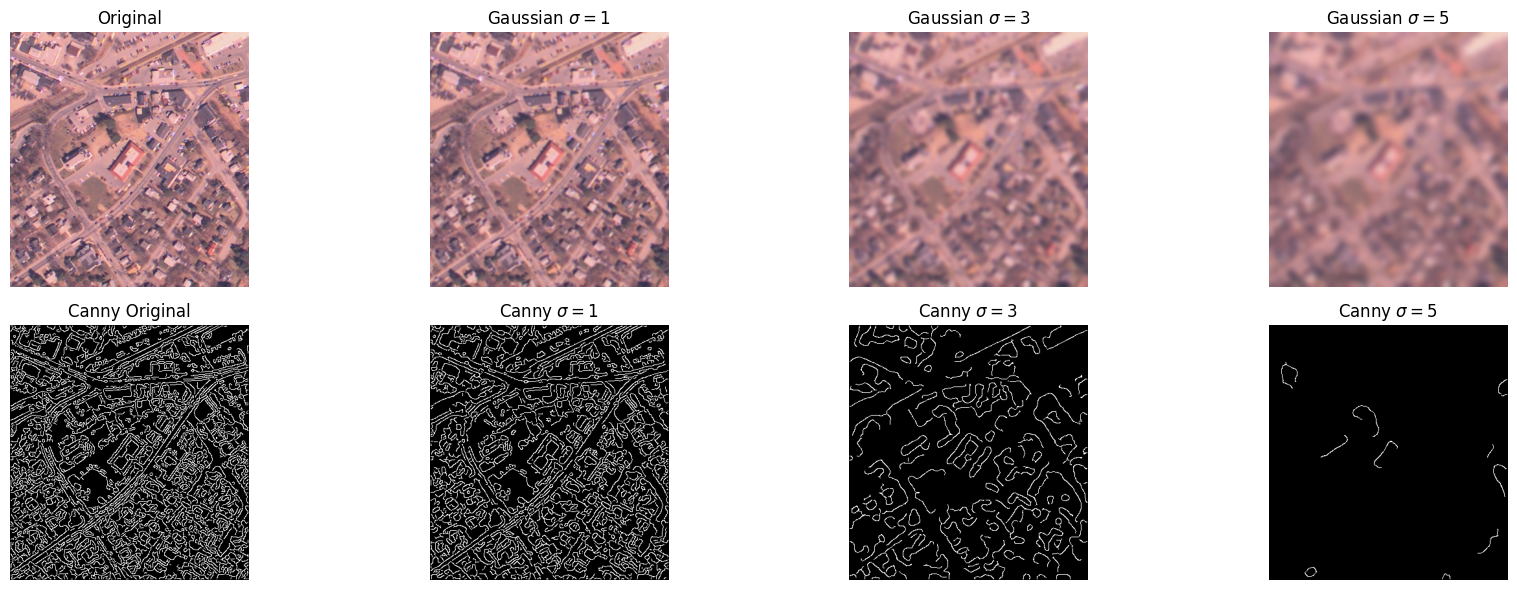

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.feature import canny

# Load the image
img = Image.open('westconcordaerial.png')

# Convert the image to a numpy array
img_array = np.array(img)

# Define a function to apply Gaussian filter to each color channel
def apply_gaussian_filter_rgb(image, sigma):
    # Split the image into its respective color channels
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    
    # Apply Gaussian filter to each channel
    r_filtered = gaussian_filter(r, sigma=sigma)
    g_filtered = gaussian_filter(g, sigma=sigma)
    b_filtered = gaussian_filter(b, sigma=sigma)
    
    # Stack the channels back together
    filtered_img = np.stack([r_filtered, g_filtered, b_filtered], axis=-1)
    
    return filtered_img

# Apply Gaussian filter with different sigmas
f1 = apply_gaussian_filter_rgb(img_array, sigma=1)
f2 = apply_gaussian_filter_rgb(img_array, sigma=3)
f3 = apply_gaussian_filter_rgb(img_array, sigma=5)

# Plotting the original and filtered images
fig, axs = plt.subplots(2, 4, figsize=(18, 6))

# Original and filtered images
axs[0, 0].imshow(img_array)
axs[0, 0].set_title('Original')
axs[0, 1].imshow(f1)
axs[0, 1].set_title('Gaussian $\sigma=1$')
axs[0, 2].imshow(f2)
axs[0, 2].set_title('Gaussian $\sigma=3$')
axs[0, 3].imshow(f3)
axs[0, 3].set_title('Gaussian $\sigma=5$')

# Convert images to grayscale for edge detection
img_gray = rgb2gray(img_array)
f1_gray = rgb2gray(f1)
f2_gray = rgb2gray(f2)
f3_gray = rgb2gray(f3)

# Applying Canny edge detection
BW_filt = canny(img_gray)
BW_filt_f1 = canny(f1_gray)
BW_filt_f2 = canny(f2_gray)
BW_filt_f3 = canny(f3_gray)

# Edge detection results
axs[1, 0].imshow(BW_filt, cmap='gray')
axs[1, 0].set_title('Canny Original')
axs[1, 1].imshow(BW_filt_f1, cmap='gray')
axs[1, 1].set_title('Canny $\sigma=1$')
axs[1, 2].imshow(BW_filt_f2, cmap='gray')
axs[1, 2].set_title('Canny $\sigma=3$')
axs[1, 3].imshow(BW_filt_f3, cmap='gray')
axs[1, 3].set_title('Canny $\sigma=5$')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()



## Effect of High and Low Threshold

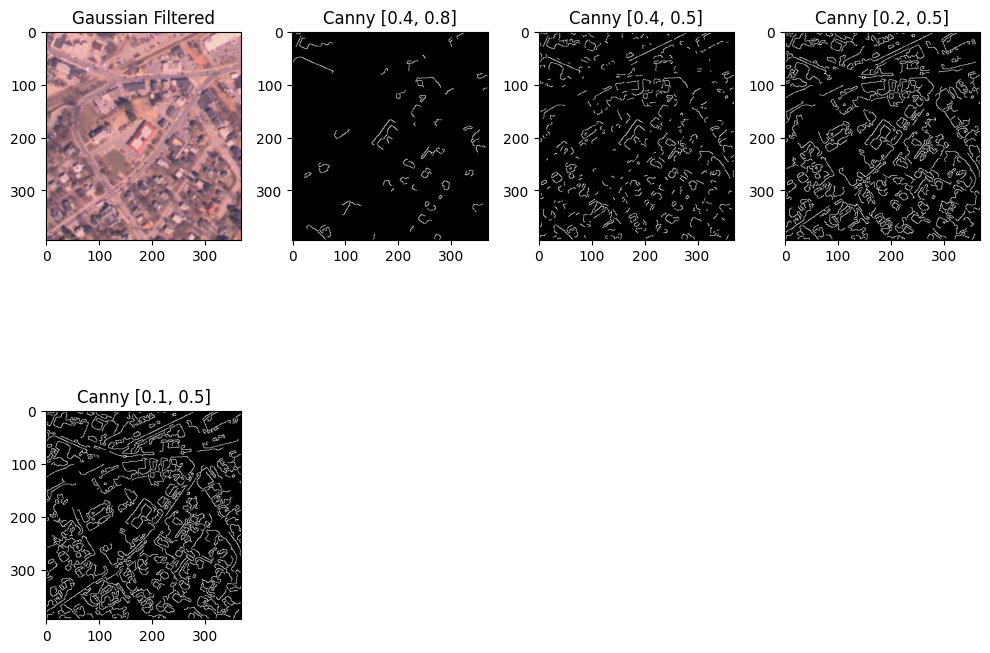

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.feature import canny

# Define a function to apply Gaussian filter to each color channel
def apply_gaussian_filter_rgb(image, sigma):
    # Split the image into its respective color channels
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    
    # Apply Gaussian filter to each channel
    r_filtered = gaussian_filter(r, sigma=sigma)
    g_filtered = gaussian_filter(g, sigma=sigma)
    b_filtered = gaussian_filter(b, sigma=sigma)
    
    # Stack the channels back together
    filtered_img = np.stack([r_filtered, g_filtered, b_filtered], axis=-1)
    
    return filtered_img

# Load the image
img = Image.open('westconcordaerial.png')

# Convert the image to a numpy array
img_array = np.array(img)

# Apply Gaussian filter
sigma = 1  # Standard deviation for Gaussian kernel, equivalent to fspecial('gaussian', 3)
img_f = apply_gaussian_filter_rgb(img_array, sigma=sigma)

# Plotting the filtered image
plt.figure(figsize=(10, 8))
plt.subplot(241)
plt.imshow(img_f)
plt.title('Gaussian Filtered')

# Convert filtered image to grayscale
img_f_gray = rgb2gray(img_f)

# Canny edge detection with different thresholds
thresholds = [(0.4, 0.8), (0.4, 0.5), (0.2, 0.5), (0.1, 0.5)]

for i, (low, high) in enumerate(thresholds, start=2):
    BW_filt = canny(img_f_gray, sigma=1, low_threshold=low, high_threshold=high)
    plt.subplot(2, 4, i)
    plt.imshow(BW_filt, cmap='gray')
    plt.title(f'Canny [{low}, {high}]')

plt.tight_layout()
plt.show()


## Beam

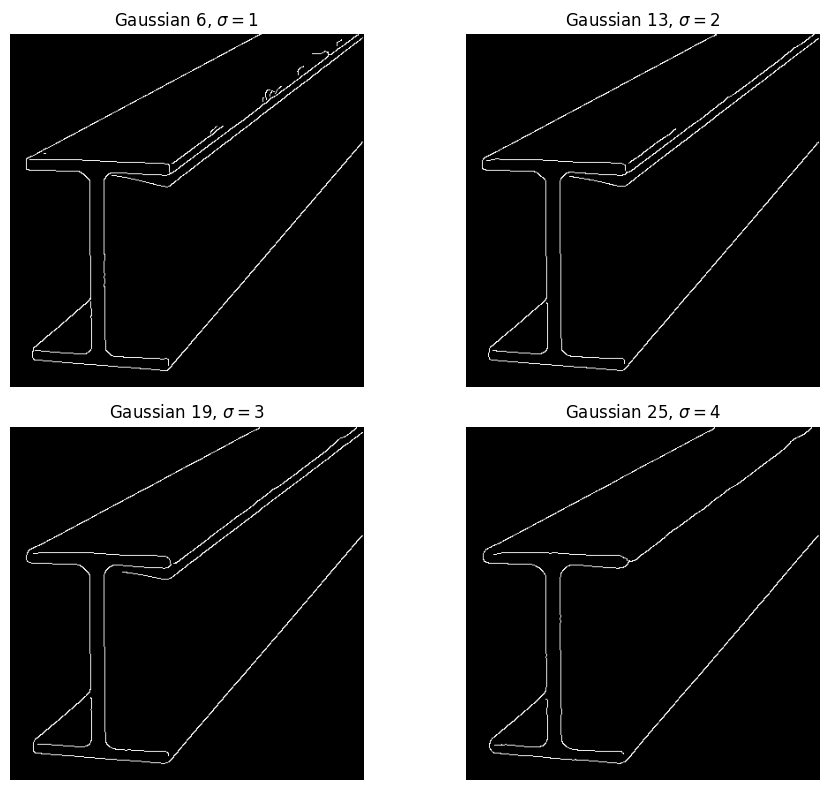

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.feature import canny

# Load the image
img = Image.open('beam.jpg')

# Convert the image to a numpy array
img_array = np.array(img)

# Define Gaussian filter parameters and apply them
filter_params = [(6, 1), (13, 2), (19, 3), (25, 4)]
images_filtered = []
edges_detected = []

# Applying Gaussian filters and Canny edge detection
for size, sigma in filter_params:
    img_filtered = gaussian_filter(img_array, sigma=sigma)
    images_filtered.append(img_filtered)
    img_gray = rgb2gray(img_filtered)
    edges = canny(img_gray)
    edges_detected.append(edges)

# Plotting the results
plt.figure(figsize=(10, 8))

titles = ['Gaussian 6, $\sigma=1$', 'Gaussian 13, $\sigma=2$', 'Gaussian 19, $\sigma=3$', 'Gaussian 25, $\sigma=4$']
for i, (edges, title) in enumerate(zip(edges_detected, titles), 1):
    plt.subplot(2, 2, i)
    plt.imshow(edges, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()
